# Evaluate Effect of Run Length
We should see it getting better with more samples acquired

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import utils
import json

## Get the runs
We want MD runs at T=500K with a target error of 1meV/atom

In [2]:
runs = list(Path('../prod-runs/').glob('dft_md-*'))
print(f'Found {len(runs)} runs')

Found 9 runs


Make sure training parameters for the network were the same

In [3]:
params = json.loads((runs[0] / 'final-model' / 'params.json').read_text())
for p in ['run_dir', 'overwrite']:
    params.pop(p)
for run in runs:
    duplicates = json.loads((run / 'duplicates.json').read_text())
    for dup in duplicates:
        dup = Path(dup)
        my_params = json.loads((dup / 'final-model' / 'params.json').read_text())
        for p in ['run_dir', 'overwrite']:
            my_params.pop(p)
        assert my_params == params, f'{dup} is different than {runs[0]}. {my_params} != {params}'

## Measure the Errors on a Hold-out Set
Get the errors for each network in force and energy for a set of structures produced by running molecular dynamics with TTM.

In [4]:
data = utils.assess_against_holdout(runs, ['num_to_run']).sort_values(['num_to_run'])
data['model'] = data['name'].apply(lambda x: x.split("_")[-1])
data

,name,num_to_run,n_duplicates,energy_error_per_atom-mean,energy_error_per_atom-sem,force_rmsd-mean,force_rmsd-sem,energy_error_per_atom-init-mean,energy_error_per_atom-init-sem,force_rmsd-init-mean,force_rmsd-init-sem,model
4,dft_md-1000_ttm-100k,1000,1,1.220583,0.115663,0.217789,0.018305,3.768881,0.671819,0.492776,0.02801,ttm-100k
5,dft_md-1000_ttm-100k-large,1000,1,1.937658,0.192614,0.212038,0.018553,3.769147,0.671883,0.492776,0.02801,ttm-100k-large
6,dft_md-1000_ttm-20k,1000,1,1.251190,0.207506,0.227609,0.017897,3.770633,0.671970,0.492776,0.02801,ttm-20k
0,dft_md-5000_ttm-100k,5000,1,1.502738,0.200275,0.183725,0.018713,3.770450,0.671845,0.492776,0.02801,ttm-100k
1,dft_md-5000_ttm-20k,5000,1,2.903021,0.225400,0.213781,0.017987,3.769339,0.671958,0.492776,0.02801,ttm-20k
3,dft_md-5000_initial,5000,1,1.793128,0.267028,0.256324,0.021908,3.769761,0.671760,0.492776,0.02801,initial
8,dft_md-5000_ttm-100k-large,5000,1,1.730604,0.211487,0.185119,0.017812,3.768636,0.671972,0.492776,0.02801,ttm-100k-large
2,dft_md-25000_ttm-100k-large,25000,1,1.437767,0.215242,0.157955,0.015358,3.769241,0.671766,0.492776,0.02801,ttm-100k-large
7,dft_md-25000_ttm-100k,25000,1,1.341553,0.219725,0.157565,0.016807,3.769850,0.671877,0.492776,0.02801,ttm-100k


We now have the errors and for each error tolerance

Make a figure

Text(0.5, 0, 'Run Length')

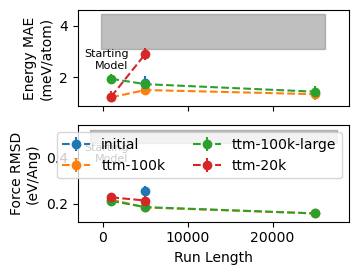

In [5]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3.5, 2.75))

#axs[0].set_xlim([0, 21])

for ax, t in zip(axs, ['energy_error_per_atom', 'force_rmsd']):
    for gid, group in data.groupby('model'):
        # Plot the tuned model
        ax.errorbar(group['num_to_run'], group[f'{t}-mean'],
                    fmt='--o', yerr=group[f'{t}-sem'], label=gid)

    # Plot the initial model
    row = data.iloc[0]
    ax.fill_between(ax.get_xlim(),
                    y1=row[f'{t}-init-mean'] + row[f'{t}-init-sem'],
                    y2=row[f'{t}-init-mean'] - row[f'{t}-init-sem'],
                   color='gray', alpha=0.5)
    ax.text(3000, row[f'{t}-init-mean'] - row[f'{t}-init-sem'], 'Starting\nModel',
           ha='right', va='top', fontsize=8)
    
ax.legend(ncol=2)
    
axs[0].set_ylabel('Energy MAE\n(meV/atom)')
axs[1].set_ylabel('Force RMSD\n(eV/Ang)')
axs[-1].set_xlabel('Run Length')

We tend to get better with more data, although the effects tend to diminish

## Evaluate suitability for basin hopping
We ran MCTBP with each potential for 100 steps then evaluated the energy of the minima it proposed using TTM. 
We measure the performance of the model based on a few different metrics:
- Energy and Force error between ML and TTM for the proposed minima to measure the quality of the potential for these structures.
- Maximum force for the proposed structure, as computed with TTM. A measure of how close to the relaxed geometry we are
- Ranking performance: Whether the minima ordered by energy via ML is close to the ranking via TTM. 

In [6]:
data = utils.assess_from_mctbp_runs(runs, ['num_to_run', 'dynamics_temp']).sort_values(['num_to_run', 'dynamics_temp'])
data['model'] = data['name'].apply(lambda x: x.split("_")[-1])
data.sort_values('force_error-mean')

,name,num_to_run,dynamics_temp,n_duplicates,number_sampled,energy_error-mean,energy_error-sem,force_error-mean,force_error-sem,max_force-mean,max_force-sem,tau-mean,tau-sem,model
7,dft_md-25000_ttm-100k,25000,300.0,1,304,1.742045,0.062592,1.178220,0.027027,0.437689,0.010790,0.817684,0.035024,ttm-100k
2,dft_md-25000_ttm-100k-large,25000,300.0,1,304,2.461398,0.081628,1.228137,0.025385,0.466349,0.010812,0.804864,0.029857,ttm-100k-large
8,dft_md-5000_ttm-100k-large,5000,300.0,1,304,1.933275,0.114444,1.328638,0.031050,0.475540,0.013523,0.770987,0.043756,ttm-100k-large
0,dft_md-5000_ttm-100k,5000,300.0,1,304,2.361383,0.092978,1.347887,0.026851,0.500690,0.011593,0.814284,0.028524,ttm-100k
5,dft_md-1000_ttm-100k-large,1000,300.0,1,304,1.725225,0.066629,1.428270,0.027191,0.508457,0.010773,0.834304,0.024440,ttm-100k-large
4,dft_md-1000_ttm-100k,1000,300.0,1,304,2.686058,0.094021,1.455046,0.026324,0.505404,0.010960,0.814158,0.030384,ttm-100k
6,dft_md-1000_ttm-20k,1000,300.0,1,304,3.839488,0.272813,1.852093,0.079004,0.749843,0.058120,0.747240,0.049820,ttm-20k
1,dft_md-5000_ttm-20k,5000,300.0,1,304,4.049748,0.385215,2.061703,0.098616,0.937960,0.074170,0.806973,0.029309,ttm-20k
3,dft_md-5000_initial,5000,300.0,1,303,8.929395,0.682462,2.708705,0.114445,1.122106,0.076382,0.652199,0.059637,initial


Plot the errors

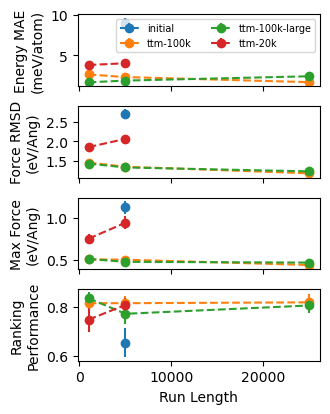

In [7]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(3.5, 4.25))

for ax, t in zip(axs, ['energy_error', 'force_error', 'max_force', 'tau']):
    for gid, group in data.groupby('model'):
        # Plot the tuned model
        ax.errorbar(group['num_to_run'], group[f'{t}-mean'],
                    fmt='--o', yerr=group[f'{t}-sem'], label=gid)
    
axs[0].set_ylabel('Energy MAE\n(meV/atom)')
axs[1].set_ylabel('Force RMSD\n(eV/Ang)')
axs[2].set_ylabel('Max Force\n(eV/Ang)')
axs[3].set_ylabel('Ranking\nPerformance')
axs[-1].set_xlabel('Run Length')
axs[0].legend(ncol=2, fontsize=7)

fig.tight_layout()

On the other hand, more data makes the optimization of structures noticeably better!

## Molecular Dynamics
See if the NNP and DFT agree for structure produced by running MD with the model

In [8]:
md_runs = pd.concat(utils.summarize_md_results(run / 'final-model', ['num_to_run']) for run in runs)
md_runs['model'] = md_runs['name'].apply(lambda x: x.split("_")[-1])

Summarize the error for timesteps over 4ps

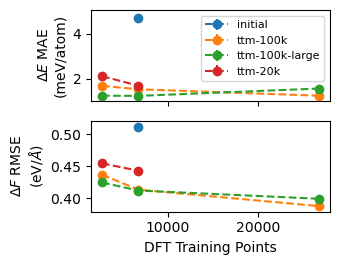

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.75), sharex=True)

initial_db = 1760
for name, group in md_runs.groupby('model'):
    # Get the error as a function of number to run
    scale = 1000  # units.mol / units.kcal
    by_count = group.groupby('num_to_run')['energy_error_per_atom'].agg(['mean', 'sem']) * scale
    axs[0].errorbar(by_count.index + initial_db, by_count['mean'], fmt='--o', yerr=by_count['sem'], label=name)
    
    by_count = group.groupby('num_to_run')['force_rmse'].agg(['mean', 'sem'])
    axs[1].errorbar(by_count.index + initial_db, by_count['mean'], fmt='--o', yerr=by_count['sem'], label=name)
    

axs[0].legend(ncol=1, fontsize=8)
axs[-1].set_xlabel('DFT Training Points')
axs[0].set_ylabel('$\Delta E$ MAE\n(meV/atom)')
axs[1].set_ylabel('$\Delta F$ RMSE\n(eV/$\\AA$)')

fig.tight_layout()
fig.savefig('figures/effect-of-pretraining-on-md.png', dpi=320)